<a href="https://colab.research.google.com/github/econ105/AI/blob/main/image_caption_blip_by_rd_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BLIP: Bulk Caption Images Automatically
 - Run each step one after other
 - Give your Google Drive permission when asked in 1 step
 - create a folder named "my_images" in your Google Drive
 - Upload images you want to caption in "my_images" folder
 - Image captions will we saved in "my_captions" folder in your Google Drive
 - Caption for each image will be saved as a text file of same name as the    image inside "my_captions" folder

# 1.Insall Required dependencies

# New Section

In [ ]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.25.1 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

from google.colab import drive

drive.mount('/content/drive')

Running in Colab.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━

#2. Get images
Upload your images to "my_images" folder in your Google Drive.

In [ ]:
from PIL import Image
import os
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_images(image_folder, image_size, device):
    images = []
    for image_name in os.listdir('/content/drive/MyDrive/my_images/'):
        img_path = os.path.join(image_folder, image_name)
        raw_image = Image.open(img_path).convert('RGB')

        w, h = raw_image.size
        display(raw_image.resize((w//5, h//5)))

        transform = transforms.Compose([
            transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
        image = transform(raw_image).unsqueeze(0).to(device)
        images.append(image)
    return images

# 3. Image Captioning
- Perform image captioning using finetuned BLIP model.
- Result will be saved in "my_captions" folder in your Google Drive

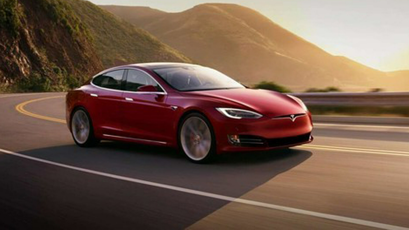

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.97G/1.97G [00:21<00:00, 98.5MB/s]


reshape position embedding from 196 to 1024
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a red tesla car on a mountain road


In [ ]:
from models.blip import blip_decoder

image_size = 512
image_folder = "/content/drive/My Drive/my_images"
images = load_demo_images('/content/drive/My Drive/my_images', image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

text_folder = '/content/drive/My Drive/my_captions'
if not os.path.exists(text_folder):
    os.makedirs(text_folder)

with torch.no_grad():
    for i, image in enumerate(images):
      caption = model.generate(image, sample=False, num_beams=3, max_length=100, min_length=5)
      print('caption: '+caption[0])
      image_name = os.listdir('/content/drive/My Drive/my_images/')[i]
      image_name = os.path.splitext(image_name)[0]
      with open(os.path.join(text_folder, f"{image_name}.txt"), "w") as f:
          f.write(caption[0])